# Autoencoders for Anomaly Detection

Based on the article at https://bit.ly/2VgNyl7, made for the bonus task of the cyber data analytics class. Download the data and adjust the paths in the next cells.

Requires 
* seaborn
* tensorflow
* keras
* sklearn
* pyplot, pylab

and for visualizing the network also the graphviz package. Install directly from the notebook with **!pip install package**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

SEED = 123 
DATA_SPLIT_PCT = 0.2

LABELS = ["Normal","Attack"]

# please adjust the dataset paths
NORMAL = "Data/training_1.csv"
MIXED = "Data/training_2.csv"

Using TensorFlow backend.


In [2]:
df_normal =  pd.read_csv(NORMAL, skipinitialspace=True)
df_mixed = pd.read_csv(MIXED, skipinitialspace=True)

Harmonize the labels across the datasets to 0 / 1

In [3]:
df_mixed.ATT_FLAG.replace([-999, 1], [0, 1], inplace=True)

Drop non-numeric columns, concatenate the dataframes.
We train the autoencoder on the normal data from BATADAL_dataset03 and test on BATADAL_dataset04

In [4]:
df_normal = df_normal.drop(['DATETIME'], axis=1)
df_mixed = df_mixed.drop(['DATETIME'], axis=1)

df = pd.concat([df_normal, df_mixed], ignore_index=True)

Splitting into training, validation, testing, group into classes

In [5]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [6]:
df_train_0 = df_train.loc[df['ATT_FLAG'] == 0]
df_train_1 = df_train.loc[df['ATT_FLAG'] == 1]

df_train_0_x = df_train_0.drop(['ATT_FLAG'], axis=1)
df_train_1_x = df_train_1.drop(['ATT_FLAG'], axis=1)


df_valid_0 = df_valid.loc[df['ATT_FLAG'] == 0]
df_valid_1 = df_valid.loc[df['ATT_FLAG'] == 1]

df_valid_0_x = df_valid_0.drop(['ATT_FLAG'], axis=1)
df_valid_1_x = df_valid_1.drop(['ATT_FLAG'], axis=1)


df_test_0 = df_test.loc[df['ATT_FLAG'] == 0]
df_test_1 = df_test.loc[df['ATT_FLAG'] == 1]

df_test_0_x = df_test_0.drop(['ATT_FLAG'], axis=1)
df_test_1_x = df_test_1.drop(['ATT_FLAG'], axis=1)

Scale the data

In [7]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['ATT_FLAG'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['ATT_FLAG'], axis = 1))

### Train the Network

In [8]:
def train_neural_net_encoder(learning_rate=1e-3):
    nb_epoch = 100
    batch_size = 128
    input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
    encoding_dim = 16
    hidden_dim = int(encoding_dim / 2)

    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    encoder = Dense(hidden_dim, activation="relu")(encoder)
    decoder = Dense(hidden_dim, activation='tanh')(encoder)
    decoder = Dense(input_dim, activation='relu')(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    
    autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

    cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                     histogram_freq=0,
                     write_graph=True,
                     write_images=True)

    history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                              epochs=nb_epoch,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                              verbose=0,
                              callbacks=[cp, tb]).history
    
    return autoencoder

## Test the network

In [9]:
nn_results = {}
for learning_rate in [1e-2, 5e-3, 1e-3, 1e-4]:
    encoder = train_neural_net_encoder(learning_rate)
    nn_results.update({str(learning_rate): encoder})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
test_data = df_test
test_data_rescaled = scaler.transform(test_data.drop(['ATT_FLAG'], axis = 1))

validation_results = {}
for name, encoder in nn_results.items():
    for detection_treshold in [1, 1.5, 2, 2.5, 3]:
        print('Calculating ', name, detection_treshold)
        valid_x_predictions = encoder.predict(test_data_rescaled)
        
        mse = np.mean(np.power(test_data_rescaled - valid_x_predictions, 2), axis=1)
        error_df = pd.DataFrame({'Reconstruction_error': mse,
                                'True_class': test_data['ATT_FLAG'] == 1})

        precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)

        test_x_predictions = encoder.predict(test_data_rescaled)
        mse = np.mean(np.power(test_data_rescaled - test_x_predictions, 2), axis=1)
        pred_y = [1 if e > detection_treshold else 0 for e in mse]

        conf_matrix = confusion_matrix(error_df.True_class, pred_y)
        validation_results.update({f'{name} - {detection_treshold}': 
                                   {
                                    'FP': conf_matrix[0][1], 
                                    'FN': conf_matrix[1][0],
                                    'TP': conf_matrix[1][1]
                                   }
                                  })

Calculating  0.01 1
Calculating  0.01 1.5
Calculating  0.01 2
Calculating  0.01 2.5
Calculating  0.01 3
Calculating  0.005 1
Calculating  0.005 1.5
Calculating  0.005 2
Calculating  0.005 2.5
Calculating  0.005 3
Calculating  0.001 1
Calculating  0.001 1.5
Calculating  0.001 2
Calculating  0.001 2.5
Calculating  0.001 3
Calculating  0.0001 1
Calculating  0.0001 1.5
Calculating  0.0001 2
Calculating  0.0001 2.5
Calculating  0.0001 3


The results for different learning rates and thresholds
{'0.0001 - 1': {'FN': 24, 'FP': 71, 'TP': 18},
 '0.0001 - 1.5': {'FN': 24, 'FP': 6, 'TP': 18},
 '0.0001 - 2': {'FN': 25, 'FP': 4, 'TP': 17},
 '0.0001 - 2.5': {'FN': 29, 'FP': 2, 'TP': 13},
 '0.0001 - 3': {'FN': 36, 'FP': 2, 'TP': 6},
 '0.001 - 1': {'FN': 24, 'FP': 92, 'TP': 18},
 '0.001 - 1.5': {'FN': 32, 'FP': 3, 'TP': 10},
 '0.001 - 2': {'FN': 36, 'FP': 3, 'TP': 6},
 '0.001 - 2.5': {'FN': 36, 'FP': 2, 'TP': 6},
 '0.001 - 3': {'FN': 36, 'FP': 2, 'TP': 6},
 '0.005 - 1': {'FN': 22, 'FP': 166, 'TP': 20},
 '0.005 - 1.5': {'FN': 24, 'FP': 14, 'TP': 18},
 '0.005 - 2': {'FN': 25, 'FP': 8, 'TP': 17},
 '0.005 - 2.5': {'FN': 25, 'FP': 8, 'TP': 17},
 '0.005 - 3': {'FN': 25, 'FP': 8, 'TP': 17},
 '0.01 - 1': {'FN': 20, 'FP': 281, 'TP': 22},
 '0.01 - 1.5': {'FN': 31, 'FP': 5, 'TP': 11},
 '0.01 - 2': {'FN': 36, 'FP': 2, 'TP': 6},
 '0.01 - 2.5': {'FN': 36, 'FP': 2, 'TP': 6},
 '0.01 - 3': {'FN': 36, 'FP': 2, 'TP': 6}}


/home/roy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]


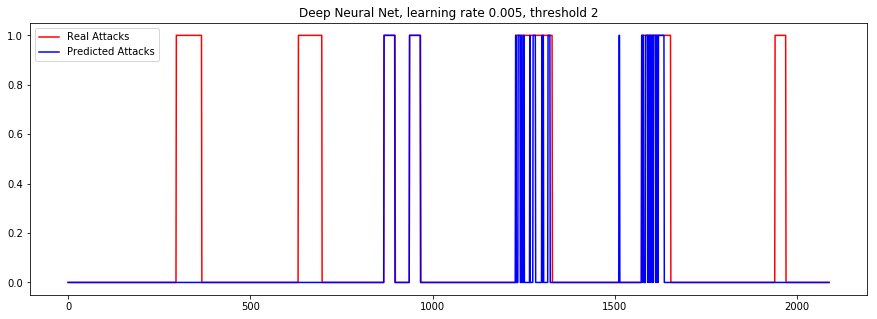

In [11]:
import pprint
print('The results for different learning rates and thresholds')
pprint.pprint(validation_results)
best_learning_rate = '0.005'
best_encoder = nn_results[best_learning_rate]
best_threshold = 2

data3 = pd.read_csv('Data/test.csv')
data3['ATT_FLAG'].fillna(0, inplace=True)
data3 = data3.drop(columns={'DATETIME'})

test_data = data3
test_data_rescaled = scaler.transform(test_data.drop(['ATT_FLAG'], axis = 1))

valid_x_predictions = best_encoder.predict(test_data_rescaled)
mse = np.mean(np.power(test_data_rescaled - valid_x_predictions, 2), axis=1)
prediction = [1 if e > best_threshold else 0 for e in mse]

plt.figure(figsize=(15,5))
plt.plot(test_data['ATT_FLAG'],'r')
plt.plot(prediction, 'b-')
plot_title = f"Deep Neural Net, learning rate {best_learning_rate}, threshold {best_threshold}"
plt.legend(['Real Attacks', 'Predicted Attacks'])
plt.title(plot_title)
plt.show()

In [12]:
VALUE_FOR_ANOMALITY_DETECTED = 1
VALUE_FOR_NORMALITY_DETECTED = 0
# This method takes a dictionary (feature: prediction) 
# and returns a dictionary with insights per sensor type
def results_of_predictions(predictions, real_attacks, combined, pp_treshold):
    results = {'ALL': {'FP': 0, 'DETECTED': 0}}
    grouped = {'ALL': combined}
    att_ranges = attack_ranges(real_attacks)
    prediction_set = set()
    # Group the predictions per sensor
    for feature, prediction in predictions.items():
        
        if feature.startswith("L_T"):
            sensor_name = "L_T"
        if feature.startswith("S_PU"):
            sensor_name = "S_PU"
        if feature.startswith("F_PU"):
            sensor_name = "F_PU"
        if feature.startswith("S_V"):
            sensor_name = "S_V"
        if feature.startswith("F_V"):
            sensor_name = "F_V"
        if feature.startswith("P_J"):
            sensor_name = "P_J"
            
        if sensor_name not in results:
            results.update({sensor_name: {'FP': 0, 'DETECTED': 0}})
            grouped.update({sensor_name: prediction})
            
        grouped_prediction = grouped[sensor_name]
        for i, p in enumerate(prediction):
            prediction_set.add(p)
            if p == 1:
                grouped_prediction[i] = 1
       
    # Process FP and detection rates
    for sensor_name, prediction in grouped.items():
        # Find the False Positives
        for i, p in enumerate(prediction):
            r = real_attacks[i]
            if r == VALUE_FOR_NORMALITY_DETECTED and p == VALUE_FOR_ANOMALITY_DETECTED:
                results[sensor_name]['FP'] += 1
                
        # Calculate the detection rate
        for (start, end) in att_ranges:
            prediction_range = prediction[start:end]
            if VALUE_FOR_ANOMALITY_DETECTED in prediction_range:
                first_index = None
                for j in range(start, end+1):
                    e = prediction[j]
                    if e == VALUE_FOR_ANOMALITY_DETECTED:
                        first_index = j
                        break
                fraction_detected = 1 - ((first_index - start) / (end-start + 1))
                results[sensor_name]['DETECTED'] += fraction_detected
        results[sensor_name]['DETECTED'] = round(results[sensor_name]['DETECTED'], 2)
    return results 


# This method returns the ranges of attacks happening in a list containing the attacks.
def attack_ranges(attacks):
    treshold_for_attack = 0.1
    ranges = []
    ctr = 0
    att_start = None
    while ctr < len(attacks):
        e = attacks[ctr]
        if e > treshold_for_attack:
            att_start = ctr
            while e > treshold_for_attack:
                ctr += 1
                e = attacks[ctr]
            att_stop = ctr - 1
            ranges.append((att_start, att_stop))
        else:
            ctr += 1
    return ranges


nn = results_of_predictions({}, data3['ATT_FLAG'], prediction, 1)
pprint.pprint(nn)

{'ALL': {'DETECTED': 4.0, 'FP': 3}}


In [13]:
import pandas as pd
rows = []
for key, d in validation_results.items():
    splitted = key.split(' - ')
    learning_rate = splitted[0]
    threshold = splitted[1]
    fn = d['FN']
    tp = d['TP']
    fp = d['FP']
    rows.append([learning_rate, threshold, fn, fp, tp])
df = pd.DataFrame(rows)
df.columns = ['LR', 'Threshold', 'FN', 'FP', 'TP']
df.to_csv('nn.csv')